# ADMM使用(TV+wavelet正則化)

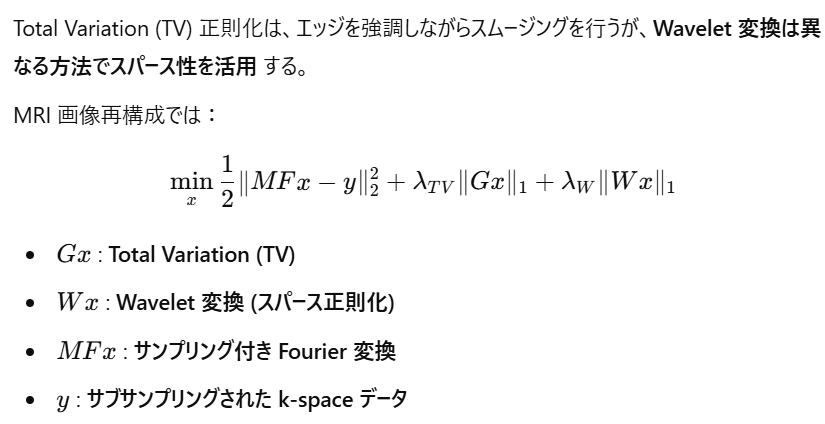

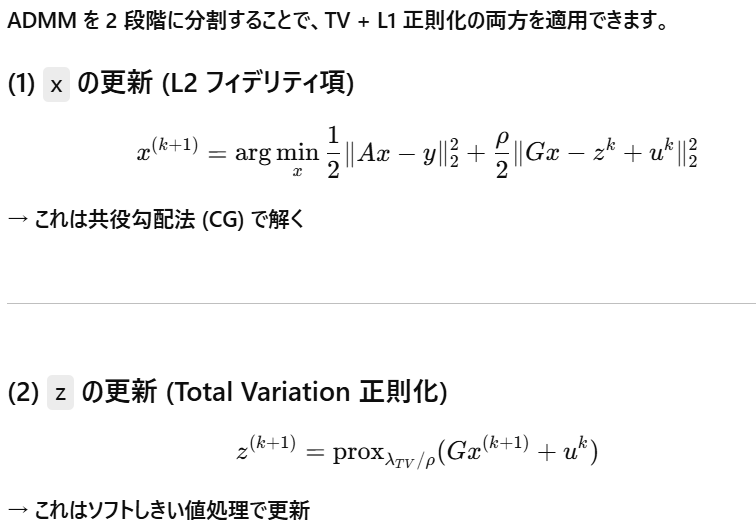

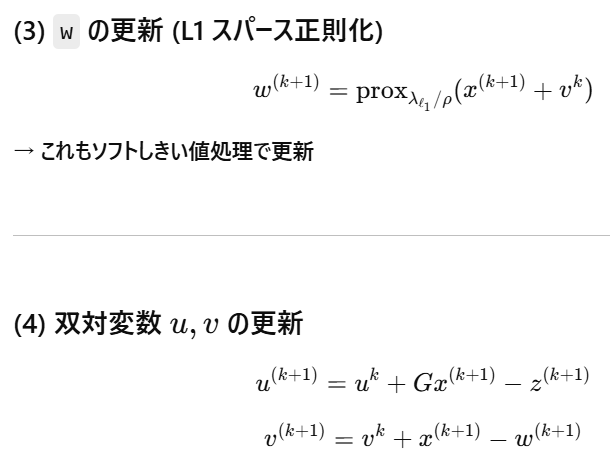

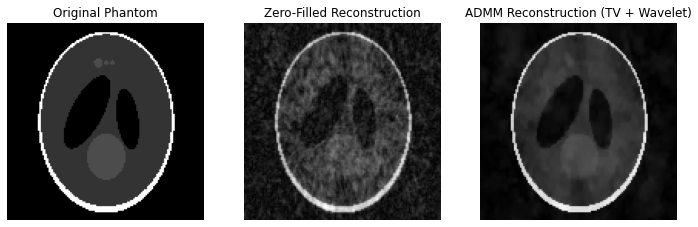

In [7]:
import sigpy as sp
import sigpy.mri as mri
import numpy as np
import matplotlib.pyplot as plt

# Shepp-Logan Phantom の作成
N = 128  # 画像サイズ
phantom = sp.shepp_logan((N, N))

# Fourier 変換して k-space を取得
kspace_full = sp.fft(phantom)

# Poisson Disc Sampling Mask を作成
mask = mri.poisson((N, N), accel=3)  # 加速率3
kspace_sampled = kspace_full * mask  # マスク適用

# 逆フーリエ変換して直接画像を取得（Zero-Filled Reconstruction）
img_zero_filled = sp.ifft(kspace_sampled).astype(np.complex128)

# ADMM のパラメータ
lambda_tv = 0.01  # TV 正則化の強さ
lambda_W = 0.01  # Wavelet スパース正則化の強さ
rho = 0.1  # ADMM のペナルティ係数

# 線形オペレータ（Fourier変換 + サンプリング）
F = sp.linop.FFT(phantom.shape)  # Fourier変換演算子
M = sp.linop.Multiply(phantom.shape, mask)  # マスク適用演算子
A = M * F  # 観測モデルの線形オペレータ

# TV正則化オペレータ
G = sp.linop.FiniteDifference(phantom.shape, axes=[0, 1])  # x, y の差分を取る

# Wavelet 正則化オペレータ
W = sp.linop.Wavelet(phantom.shape, wave_name="db4", level=4)  # Wavelet 変換

# 初期化
x = np.zeros_like(img_zero_filled, dtype=np.complex128)  # ゼロ初期化
z = np.zeros(G.oshape, dtype=np.complex128)
w_W = np.zeros(W.oshape, dtype=np.complex128)  # Wavelet の出力サイズ
u = np.zeros(G.oshape, dtype=np.complex128)
v_W = np.zeros(W.oshape, dtype=np.complex128)

# ADMM の反復更新
max_iter = 100
for i in range(max_iter):
    # x の更新 (CG 法)
    AHA = A.H * A + rho * (G.H * G + W.H * W + sp.linop.Identity(x.shape))
    b = A.H(kspace_sampled) + rho * (G.H * (z - u)).reshape(x.shape) + rho * (W.H * (w_W - v_W)).reshape(x.shape)
    cg_solver = sp.alg.ConjugateGradient(AHA, b, x, max_iter=10)
    while not cg_solver.done():
        cg_solver.update()

    # z の更新 (TV 正則化, ソフトしきい値処理)
    z = sp.prox.L1Reg(G.oshape, lambda_tv / rho)(1.0, G * x + u)

    # w_W の更新 (Wavelet スパース正則化, ソフトしきい値処理)
    w_W = sp.prox.L1Reg(W.oshape, lambda_W / rho)(1.0, W * x + v_W)

    # 双対変数の更新
    u += G * x - z
    v_W += W * x - w_W

# 結果を取得
reconstructed_img = np.abs(x)  # 絶対値を取って実画像にする

# 結果を可視化
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.abs(phantom), cmap="gray")
axs[0].set_title("Original Phantom")
axs[0].axis("off")

axs[1].imshow(np.abs(img_zero_filled), cmap="gray")
axs[1].set_title("Zero-Filled Reconstruction")
axs[1].axis("off")

axs[2].imshow(reconstructed_img, cmap="gray")
axs[2].set_title("ADMM Reconstruction (TV + Wavelet)")
axs[2].axis("off")

plt.show()
